In [1]:
import cv2
import numpy as np
import matplotlib

%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [2]:
import glob

vehicles = glob.glob("./data/vehicles/*/*")
non_vehicles = glob.glob("./data/non-vehicles/*/*")

print("{} images marked as vehicle.".format(len(vehicles)))
print("{} images marked as non-vehicles.".format(len(non_vehicles)))

8792 images marked as vehicle.
8968 images marked as non-vehicles.


In [3]:
image_shape = mpimg.imread(vehicles[0]).shape

print("Image has shape of {}".format(image_shape))

Image has shape of (64, 64, 3)


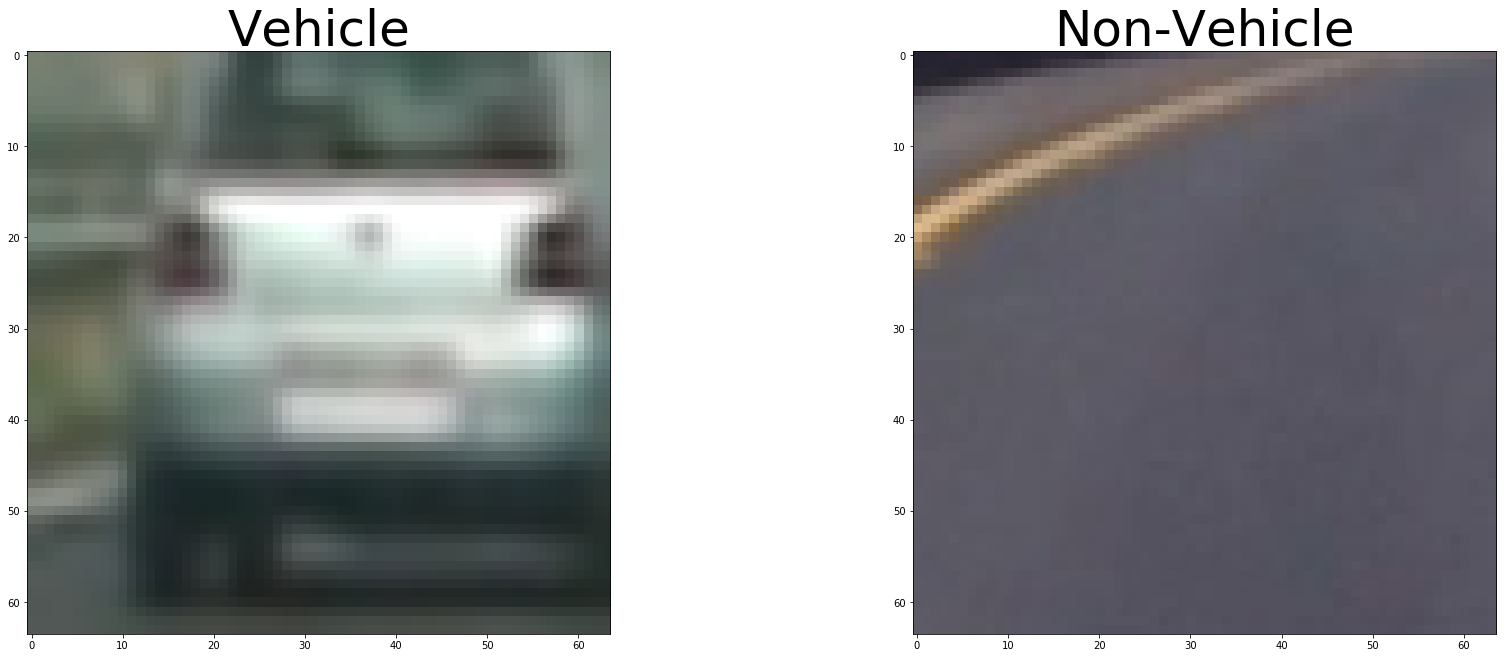

In [4]:
def image_row_show(images, titles, figsize=(24, 9), fontsize=50, cmaps=None):
    num_images = len(images)
    
    f, axes = plt.subplots(1, num_images, figsize=figsize)
    f.tight_layout()
    
    if cmaps is None:
        cmaps = [None] * num_images
    
    for ax, img, title, cmap in zip(axes, images, titles, cmaps):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title, fontsize=fontsize)
    plt.subplots_adjust(left=0., right=1., top=0.9, bottom=0.)

image_row_show([mpimg.imread(vehicles[100]), mpimg.imread(non_vehicles[100])], ["Vehicle", "Non-Vehicle"])

In [5]:
from skimage.feature import hog

def convert_color(image, color_space):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image) 
    return feature_image

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32, cmap="RGB"):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    ranges = {
        "RGB": [(0, 256), (0, 256), (0, 256)],
        "HSV": [(0, 360), (0, 1), (0, 1)],
        "HLS": [(0, 360), (0, 1), (0, 1)],
        "YCrCb": [(0, 1), (0.4, 0.6), (0.4, 0.6)],
    }
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=ranges[cmap][0])
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=ranges[cmap][1])
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=ranges[cmap][2])
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

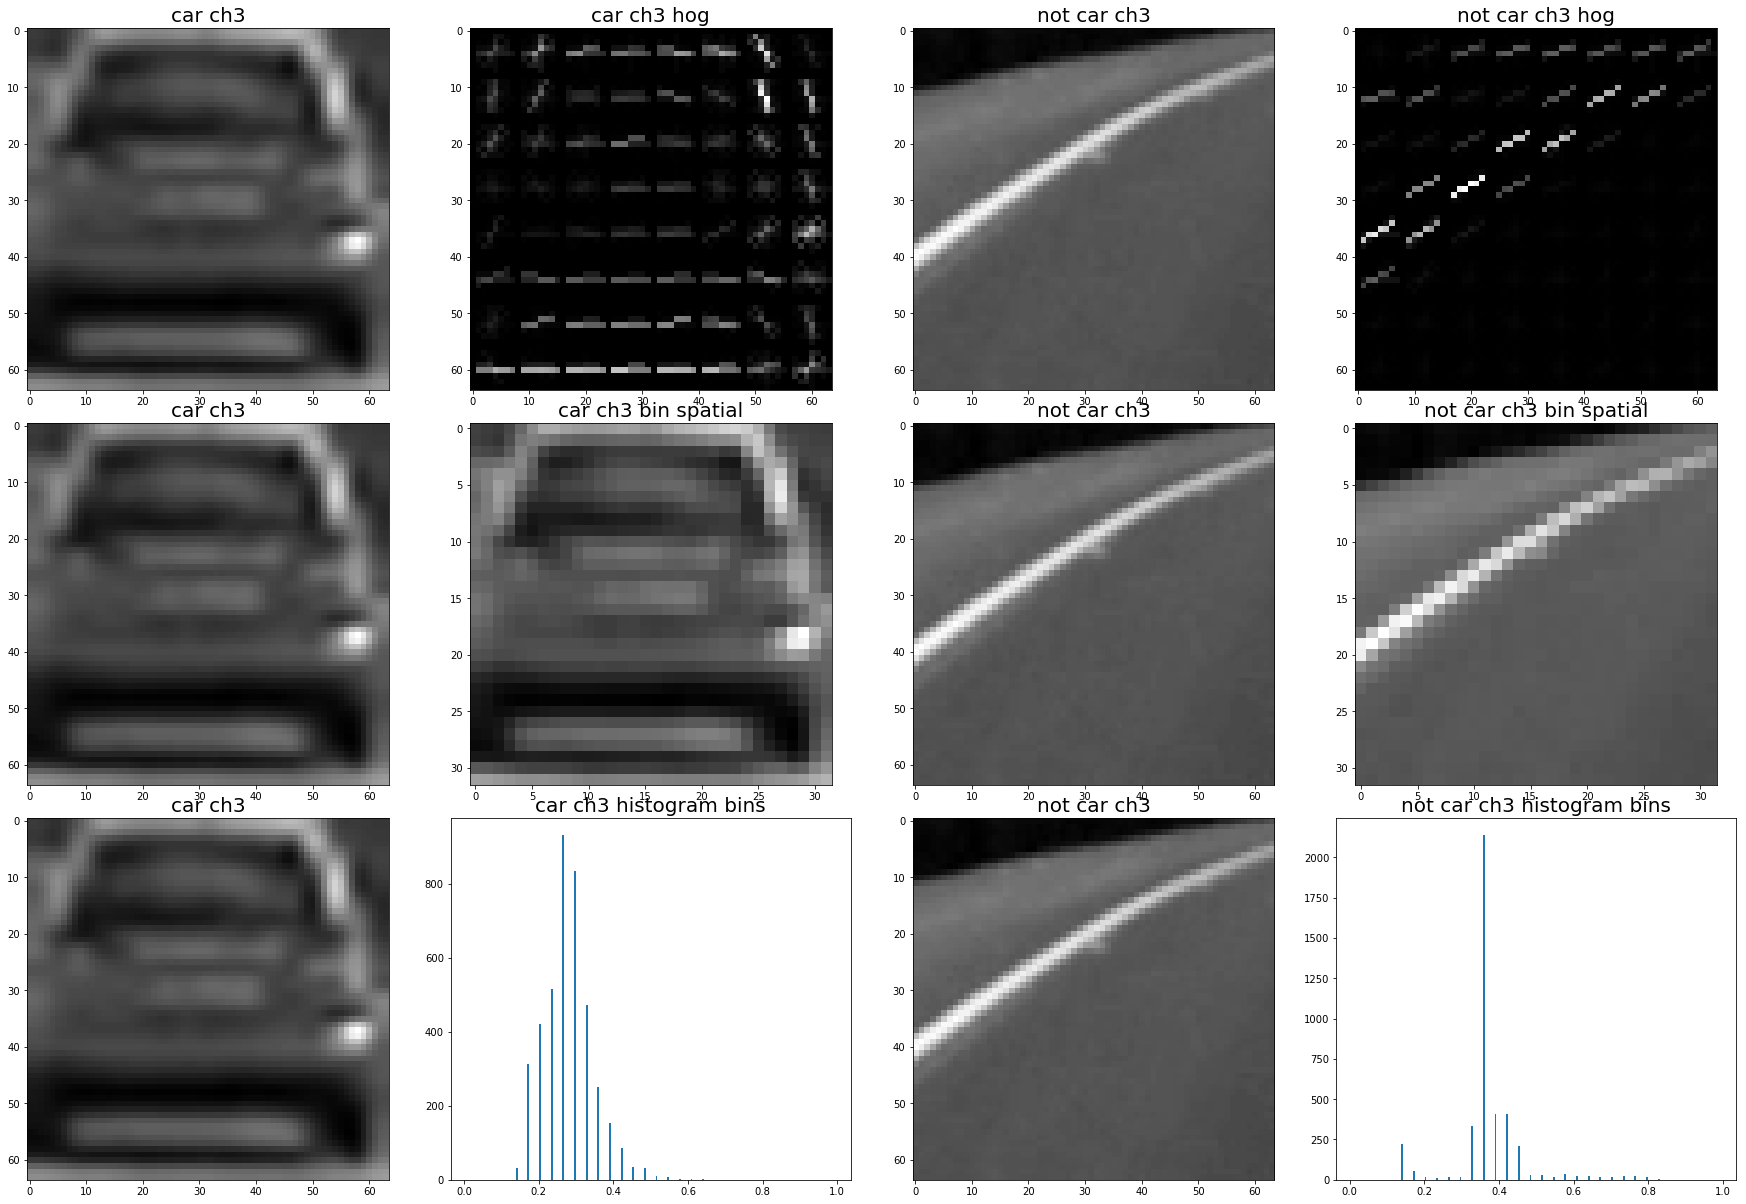

In [6]:
color_space = "YCrCb"
orient = 36
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32

test_car = convert_color(mpimg.imread(vehicles[10]), color_space)
test_not_car = convert_color(mpimg.imread(non_vehicles[10]), color_space)

_, car_hog = get_hog_features(test_car[:, :, 0], orient, pix_per_cell, cell_per_block, True, False)
_, not_car_hog = get_hog_features(test_not_car[:, :, 0], orient, pix_per_cell, cell_per_block, True, False)

f, axes = plt.subplots(3, 4, figsize=(24, 16))
f.tight_layout()

car_hist = np.histogram(test_car[:,:,0], bins=hist_bins, range=(0, 1))
car_bin_edges = car_hist[1]
car_bin_centers = (car_bin_edges[1:]  + car_bin_edges[0:-1])/2

not_car_hist = np.histogram(test_not_car[:,:,0], bins=hist_bins, range=(0, 1))
not_car_bin_edges = not_car_hist[1]
not_car_bin_centers = (not_car_bin_edges[1:]  + not_car_bin_edges[0:len(not_car_bin_edges)-1])/2

axes[0][0].imshow(test_car[:, :, 0], cmap='gray')
axes[0][0].set_title("car ch3", fontsize=20)
axes[0][1].imshow(car_hog, cmap='gray')
axes[0][1].set_title("car ch3 hog", fontsize=20)
axes[0][2].imshow(test_not_car[:, :, 0], cmap='gray')
axes[0][2].set_title("not car ch3", fontsize=20)
axes[0][3].imshow(not_car_hog, cmap='gray')
axes[0][3].set_title("not car ch3 hog", fontsize=20)

axes[1][0].imshow(test_car[:, :, 0], cmap='gray')
axes[1][0].set_title("car ch3", fontsize=20)
axes[1][1].imshow(cv2.resize(test_car, spatial_size)[:, :, 0], cmap='gray')
axes[1][1].set_title("car ch3 bin spatial", fontsize=20)
axes[1][2].imshow(test_not_car[:, :, 0], cmap='gray')
axes[1][2].set_title("not car ch3", fontsize=20)
axes[1][3].imshow(cv2.resize(test_not_car, spatial_size)[:, :, 0], cmap='gray')
axes[1][3].set_title("not car ch3 bin spatial", fontsize=20)

axes[2][0].imshow(test_car[:, :, 0], cmap='gray')
axes[2][0].set_title("car ch3", fontsize=20)
axes[2][1].bar(car_bin_centers, car_hist[0], width=1/200)
axes[2][1].set_title("car ch3 histogram bins", fontsize=20)
axes[2][2].imshow(test_not_car[:, :, 0], cmap='gray')
axes[2][2].set_title("not car ch3", fontsize=20)
axes[2][3].bar(not_car_bin_centers, not_car_hist[0], width=1/200)
axes[2][3].set_title("not car ch3 histogram bins", fontsize=20)
plt.subplots_adjust(left=0., right=1., top=1.0, bottom=0.)

In [7]:
hog_channel = "ALL"
spatial_feat = False
hist_feat = True
hog_feat = True

car_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


In [8]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import time

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

/Users/dtong/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using: 36 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 21264
54.59 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9873


In [9]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            features = []
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
          
            # Get color features
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                features.append(spatial_features)
                
            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)
                features.append(hist_features)
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            features.append(hog_features)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(features).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bbox_list

def draw_boxes(img, bbox_list, color=(0,0,255)):
    draw_img = np.copy(img)
    for box in bbox_list:
        cv2.rectangle(draw_img,box[0],box[1],color,6) 
    return draw_img

def draw_all_boxes(image, ystart, ystop, scales, window, step):
    img_tosearch = image[ystart:ystop,:,:]
    imshape = img_tosearch.shape
    output = np.copy(image)
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]
    for scale, color in zip(scales, colors):
        nxsteps = (imshape[1] - window) // step
        nysteps = (imshape[0] - window) // step
        bbox_list = []
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*step
                xpos = xb*step
                xleft = xpos
                ytop = ypos
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
        output = draw_boxes(output, bbox_list, color)
    return output

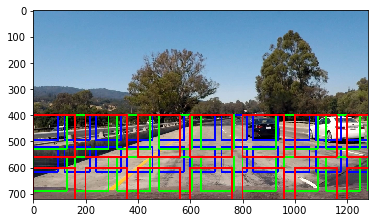

In [10]:
test_images = glob.glob("./test_images/*")

ystart = 400
ystop = 656

tmp_img = mpimg.imread(test_images[0])

output = draw_all_boxes(tmp_img, 400, 656, np.arange(1.5, 3.0, 0.5), 64, 80)
plt.imshow(output)

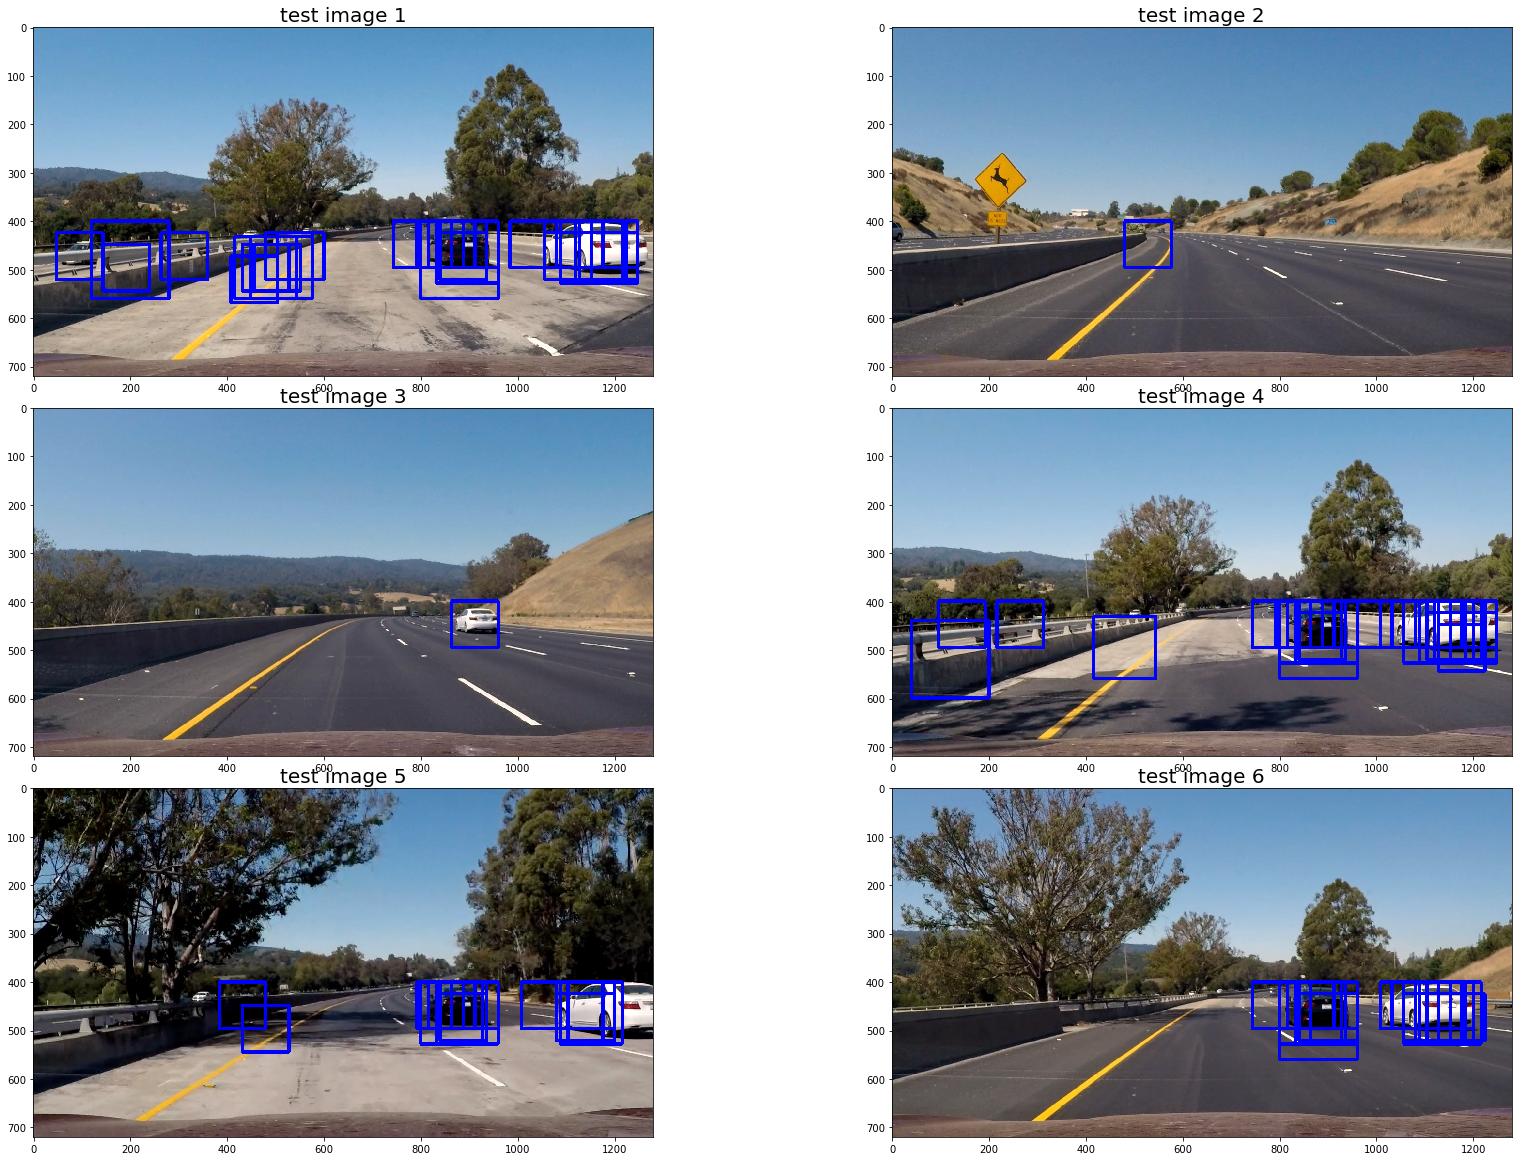

In [11]:
test_images = glob.glob("./test_images/*")

ystart = 400
ystop = 656

outputs = []
for p in test_images:
    tmp_img = mpimg.imread(p)
    boxes = []
    for scale in np.arange(1.5, 3.0, 0.5):
        tmp_boxes = find_cars(tmp_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        boxes.extend(tmp_boxes)

    outputs.append(draw_boxes(tmp_img, boxes))

f, axes = plt.subplots(3, 2, figsize=(24, 16))
f.tight_layout()

for i, output in enumerate(outputs):
    row, col = divmod(i, 2)
    axes[row][col].imshow(output)
    axes[row][col].set_title("test image {}".format(i + 1), fontsize=20)

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

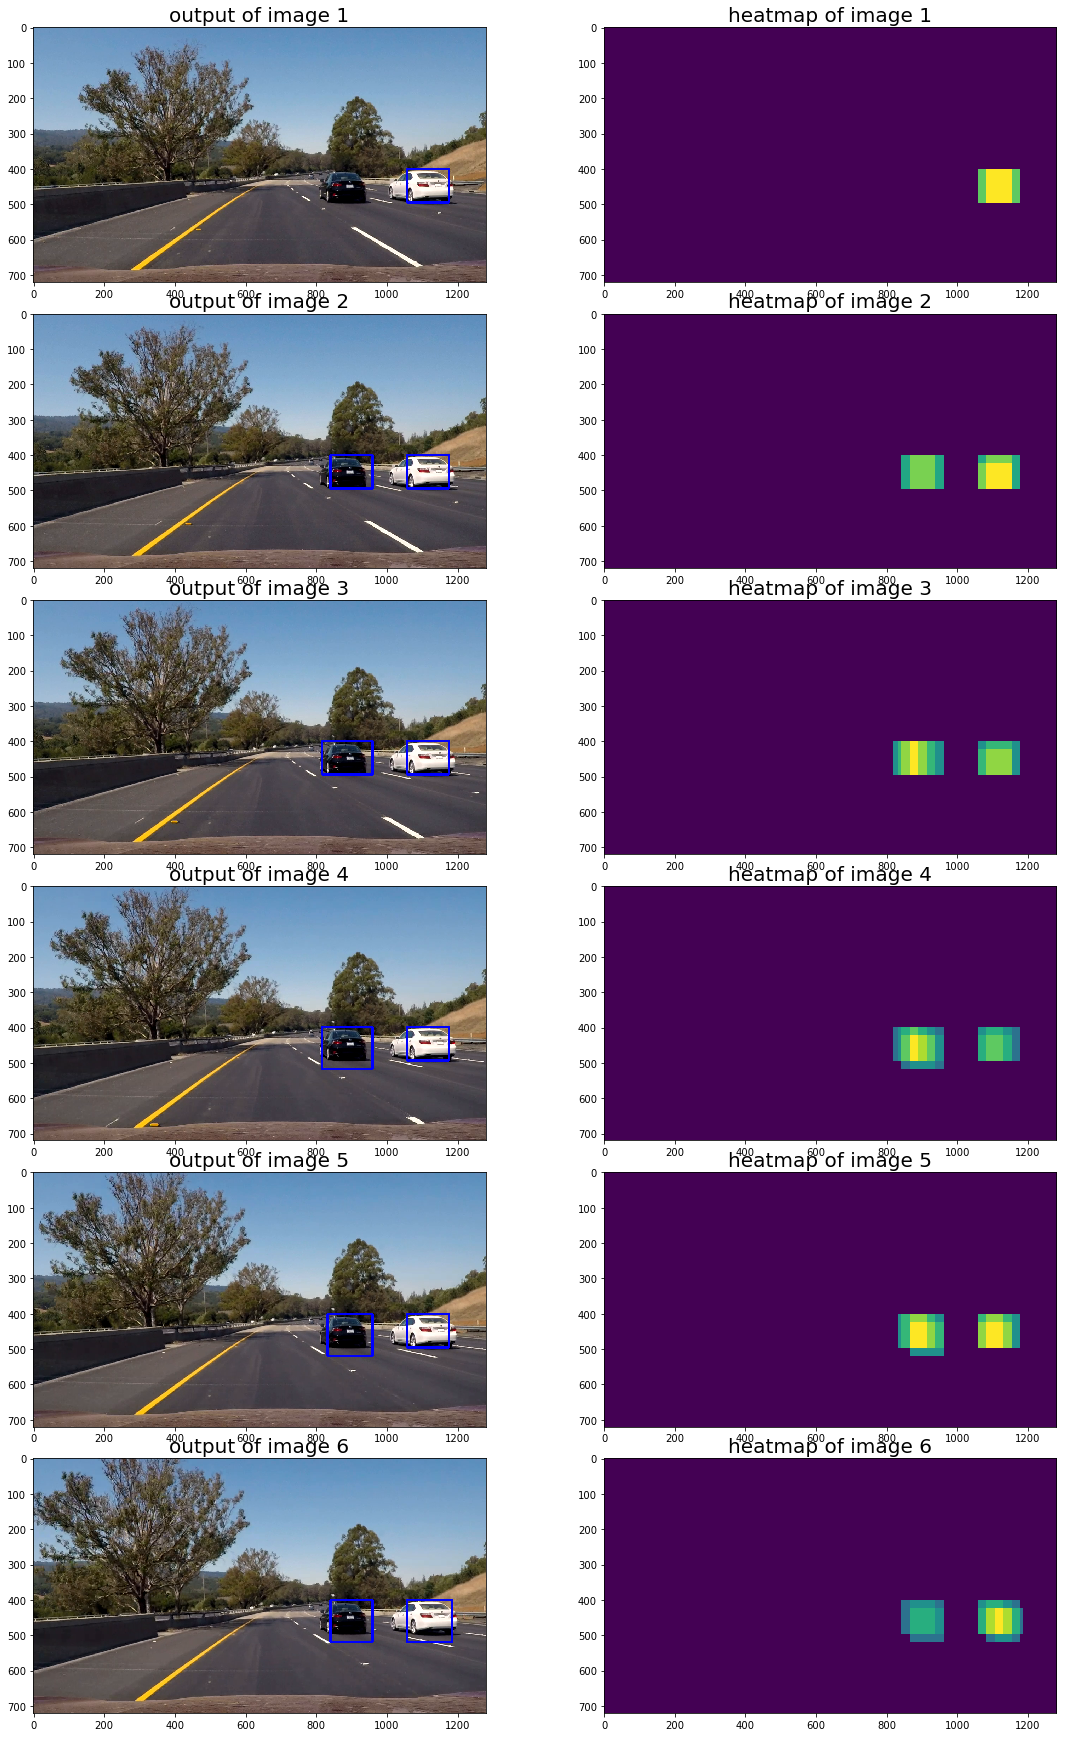

In [14]:
from scipy.ndimage.measurements import label

clip1 = VideoFileClip("test_video.mp4")

outputs = []
heatmaps = []
for i, tmp_img in enumerate(clip1.iter_frames()):
    if i >= 6:
        break
    boxes = []
    for scale in np.arange(1.5, 3.0, 0.5):
        tmp_boxes = find_cars(tmp_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        boxes.extend(tmp_boxes)
    
    heat = np.zeros_like(tmp_img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    heatmaps.append(heatmap)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    outputs.append(draw_labeled_bboxes(np.copy(tmp_img), labels))

f, axes = plt.subplots(len(outputs), 2, figsize=(16, 24))
f.tight_layout()

for i, (output, heatmap) in enumerate(zip(outputs, heatmaps)):
    axes[i][0].imshow(output)
    axes[i][0].set_title("output of image {}".format(i + 1), fontsize=20)
    axes[i][1].imshow(heatmap)
    axes[i][1].set_title("heatmap of image {}".format(i + 1), fontsize=20)

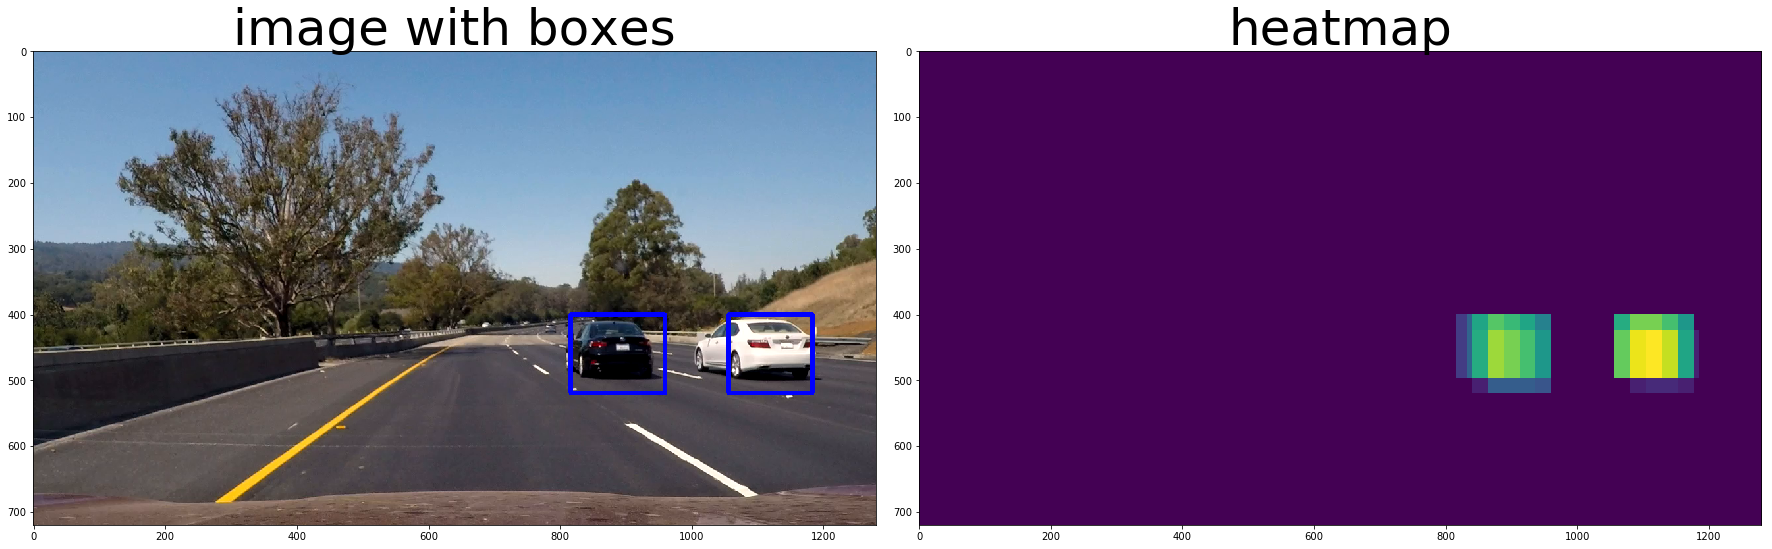

In [15]:
heatmap = np.average(np.stack(heatmaps, -1), axis=2)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(next(clip1.iter_frames())), labels)

image_row_show([draw_img, heatmap], ["image with boxes", "heatmap"])

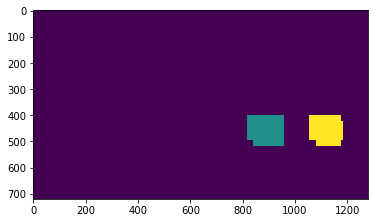

In [16]:
plt.imshow(labels[0])

In [23]:
from collections import deque
from itertools import chain

class Processor(object):
    def __init__(self):
        self.heatmaps = deque(maxlen=6)
    
    def process(self, image):
        boxes = []
        for scale in np.arange(1.5, 3.0, 0.5):
            tmp_boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            boxes.extend(tmp_boxes)
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = add_heat(heat, boxes)
        heat = apply_threshold(heat, 2)
        heatmap = np.clip(heat, 0, 255)
        self.heatmaps.append(heatmap)
        avg_heatmap = np.average(np.stack(self.heatmaps, -1), axis=2)
        labels = label(avg_heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)

        return draw_img

In [24]:
project_output = "project-output.mp4"

processor = Processor()
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(processor.process)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project-output.mp4
[MoviePy] Writing video project-output.mp4


100%|█████████▉| 1260/1261 [14:46<00:00,  1.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project-output.mp4 

CPU times: user 13min 33s, sys: 1min 20s, total: 14min 53s
Wall time: 14min 47s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))